In [26]:
import tushare as ts
import pandas as pd
from datetime import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 15, 5
%matplotlib inline

# 特征探索

获取数据

In [2]:
# 获取股票002639从2016-01-01到2016-12-31的历史数据
wdyx = ts.get_hist_data('002639', start='2017-01-01', end='2017-12-31')
wdyx.tail()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2017-01-09,12.30,12.30,12.01,11.88,163287.48,-0.34,-2.75,12.424,12.523,13.042,162423.50,202557.31,338922.13
2017-01-06,12.61,12.64,12.35,12.27,160914.52,-0.29,-2.29,12.488,12.656,13.147,154119.57,229347.70,353776.00
2017-01-05,12.75,12.78,12.64,12.57,144837.61,-0.13,-1.02,12.478,12.756,13.229,155219.08,265822.89,367446.35
2017-01-04,12.31,12.78,12.77,12.31,224608.69,0.42,3.40,12.410,12.904,13.316,185900.55,306314.15,383326.40
2017-01-03,12.49,12.49,12.35,12.26,118469.22,0.02,0.16,12.432,13.052,13.398,202949.65,355270.37,399382.41


Text(0.5,1,'Snow boy Closing rate - Year 2016')

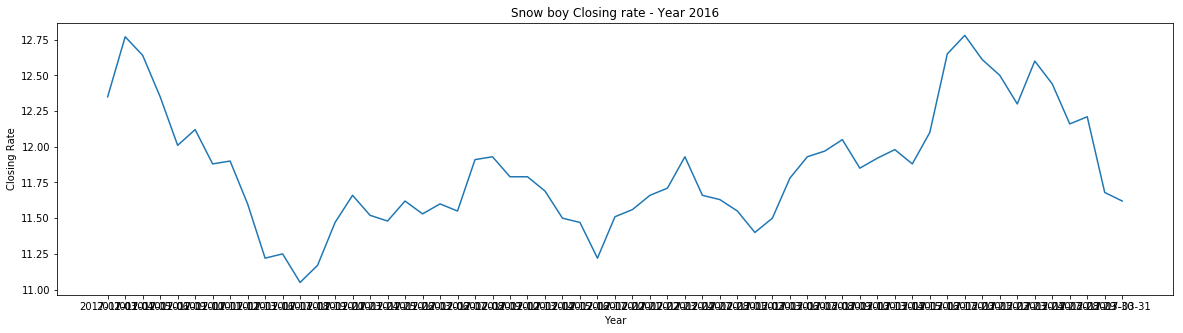

In [3]:
datas = list(deepcopy(wdyx.index))
values = list(deepcopy(wdyx['close']))
data = pd.DataFrame({'Close': values}, index=datas)
# 根据指定的格式把一个时间字符串解析为时间元组。本代码中把2016-10-01作为train/test的切分点
# date_thresh = datetime.strptime('2016-10-01', '%Y-%m-%d').date()
index = list(np.arange(len(data)))
data['index'] = index
data = data.sort_values(by=['index'], ascending=(False))
data.drop('index',axis=1, inplace=True)
datas = list(deepcopy(wdyx.index))
ind_ = datas.index('2017-10-09')
data_train = data.iloc[: ind_]
data_test = data.iloc[ind_ :]
plt.figure(figsize=(20,5))
plt.plot(data_train.index, data_train['Close'])
plt.xlabel('Year')
plt.ylabel('Closing Rate')
plt.title('Snow boy Closing rate - Year 2016')

# 评估时间序列对象的平稳性

测试时间序列对象是否平稳

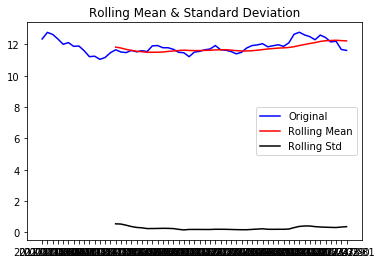

Dickey-Fuller test
测试统计                     -2.090433
p-value                   0.248379
使用延迟                      0.000000
使用的观察次数                  58.000000
Cirtical Value (1%)      -3.548494
Cirtical Value (5%)      -2.912837
Cirtical Value (10%)     -2.594129
dtype: float64


In [4]:
def evaluate_stationarity(timeseries, t=30):
    # 也就是t个数取一个均值，不够t个变为NaN
    rolmean = timeseries.rolling(window=t).mean()
    # 也就是t个数取一个标准差，不够t个变为NaN
    rolstd = timeseries.rolling(window=t).std()
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    # matplotlib绘图显示同时继续跑下面的代码
    plt.show(block=False)
    print('Dickey-Fuller test')
    # 利用Dickey-Fuller进行平稳性检验
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['测试统计', 'p-value', '使用延迟', '使用的观察次数'])
    for key, value in dftest[4].items():
        dfoutput['Cirtical Value (%s) ' % key] = value
    print(dfoutput)
evaluate_stationarity(data_train['Close'], 15)

将对数变换应用于时间序列对象

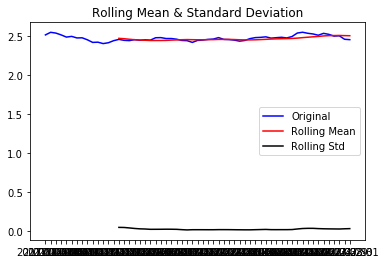

Dickey-Fuller test
测试统计                     -2.092691
p-value                   0.247464
使用延迟                      0.000000
使用的观察次数                  58.000000
Cirtical Value (1%)      -3.548494
Cirtical Value (5%)      -2.912837
Cirtical Value (10%)     -2.594129
dtype: float64


In [5]:
data_log = np.log(data_train['Close'])
evaluate_stationarity(data_log, 15)

对数变换分布的滚动均值放大图

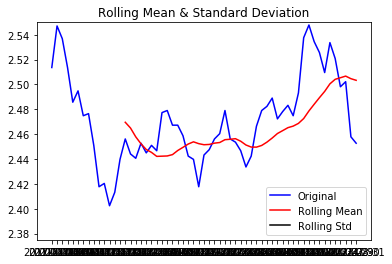

In [6]:
data_log = np.log(data_train['Close'])
rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()
orig = plt.plot(data_log, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.ylim([2.375, 2.55])
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

将四次方根变换应用于时间序列对象

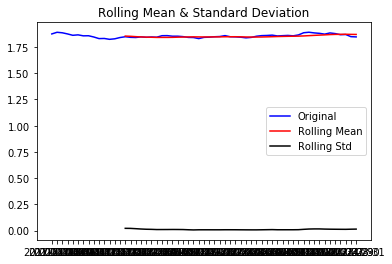

Dickey-Fuller test
测试统计                     -2.091946
p-value                   0.247766
使用延迟                      0.000000
使用的观察次数                  58.000000
Cirtical Value (1%)      -3.548494
Cirtical Value (5%)      -2.912837
Cirtical Value (10%)     -2.594129
dtype: float64


In [7]:
data_sqrt = np.sqrt(np.sqrt(data_train['Close']))
evaluate_stationarity(data_sqrt, 15)

将移动平均平滑应用到时间序列对象

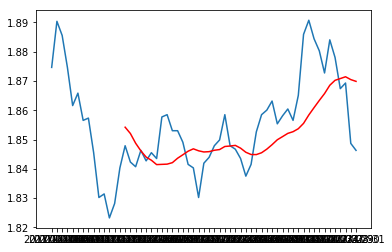

In [8]:
moving_avg = data_sqrt.rolling(15).mean()
plt.plot(data_sqrt)
plt.plot(moving_avg, color='red')

打印无趋势时间序列对象

In [9]:
data_sqrt_moving_avg_diff = data_sqrt - moving_avg
data_sqrt_moving_avg_diff.head(15)

2017-01-03         NaN
2017-01-04         NaN
2017-01-05         NaN
2017-01-06         NaN
2017-01-09         NaN
2017-01-10         NaN
2017-01-11         NaN
2017-01-12         NaN
2017-01-13         NaN
2017-01-16         NaN
2017-01-17         NaN
2017-01-18         NaN
2017-01-19         NaN
2017-01-20         NaN
2017-01-23   -0.006329
Name: Close, dtype: float64

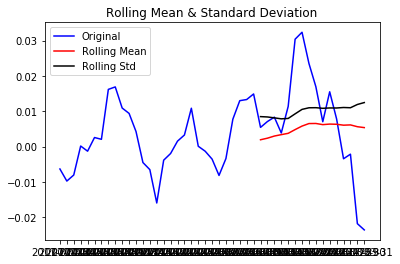

Dickey-Fuller test
测试统计                     -1.683012
p-value                   0.439886
使用延迟                      0.000000
使用的观察次数                  44.000000
Cirtical Value (1%)      -3.588573
Cirtical Value (5%)      -2.929886
Cirtical Value (10%)     -2.603185
dtype: float64


In [10]:
data_sqrt_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_sqrt_moving_avg_diff)

指数加权移动平均平滑在时间序列对象中的应用

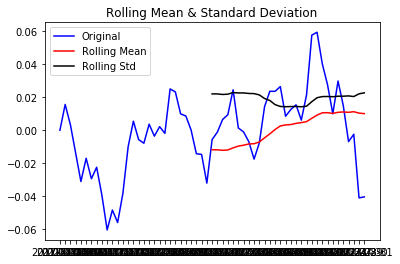

Dickey-Fuller test
测试统计                     -2.309256
p-value                   0.169000
使用延迟                      1.000000
使用的观察次数                  57.000000
Cirtical Value (1%)      -3.550670
Cirtical Value (5%)      -2.913766
Cirtical Value (10%)     -2.594624
dtype: float64


In [11]:
expwighted_avg = data_log.ewm(span=15).mean()
data_log_ewma_diff = data_log - expwighted_avg
evaluate_stationarity(data_log_ewma_diff)

将一阶差分应用于时间序列对象的对数版本

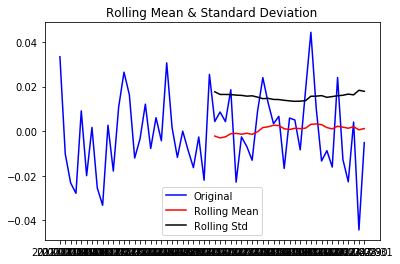

Dickey-Fuller test
测试统计                    -7.088878e+00
p-value                  4.463806e-10
使用延迟                     0.000000e+00
使用的观察次数                  5.700000e+01
Cirtical Value (1%)     -3.550670e+00
Cirtical Value (5%)     -2.913766e+00
Cirtical Value (10%)    -2.594624e+00
dtype: float64


In [12]:
# period：表示移动的幅度，可以是正数，也可以是负数，默认值是1,1就表示移动一次，注意这里移动的都是数据，而索引是不移动的，移动之后没有对应值的，就赋值为NaN。
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

分解对数变换后的时间序列

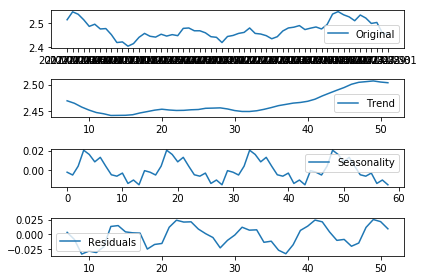

In [13]:
# 返回包含三个部分trend(趋势部分)，seasonal(季节性部分)和residual(残留部分)
decomposition = seasonal_decompose(list(data_log), freq=15)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

为平稳性评估残差

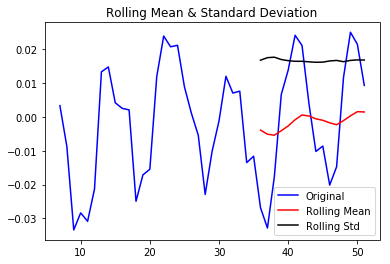

Dickey-Fuller test
测试统计                     -3.288841
p-value                   0.015385
使用延迟                     10.000000
使用的观察次数                  34.000000
Cirtical Value (1%)      -3.639224
Cirtical Value (5%)      -2.951230
Cirtical Value (10%)     -2.614447
dtype: float64


In [14]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

# 测试以确定时间序列是否具有自相关性

计算对数变换差分后的时间序列的Durbin Watson统计

In [15]:
sm.stats.durbin_watson(data_log_diff)

1.7666501487042174

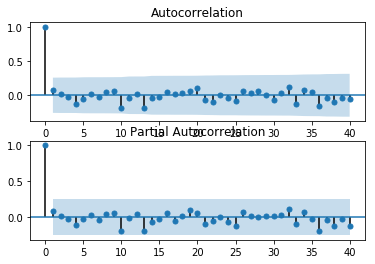

In [16]:
ax1 = plt.subplot(211)
# 绘制自相关函数ACF
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
# 绘制偏自相关函数PACF
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

# 自回归综合移动平均

将AR模型应用到差分对数变换时间序列上

Text(0.5,1,'RSS: 0.0177')

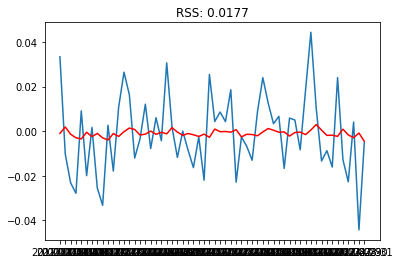

In [17]:
# p=2, d=1, q=0
model = ARIMA(data_log, order=(2, 1, 0), dates=pd.to_datetime(data_log.index))
results_AR_210 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_210.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_AR_210.fittedvalues-data_log_diff)**2))

将MA模型应用到差分对数变换时间序列上

Text(0.5,1,'RSS: 0.0177')

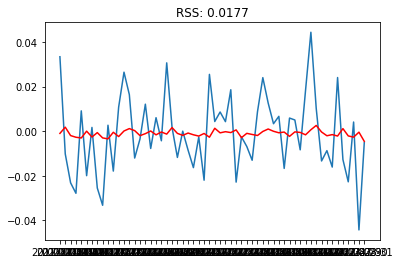

In [18]:
# d=1, q=1
model = ARIMA(data_log, order=(0, 1, 1), dates=pd.to_datetime(data_log.index))
results_MA_011 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_MA_011.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_MA_011.fittedvalues-data_log_diff)**2))

Text(0.5,1,'RSS: 0.0177')

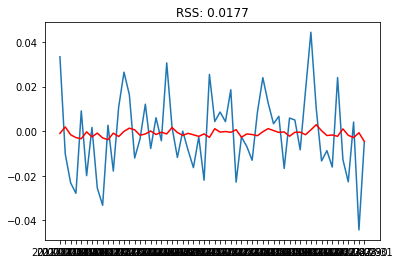

In [19]:
# p=1, d=1, q=1
model = ARIMA(data_log, order=(1, 1, 1), dates=pd.to_datetime(data_log.index))
results_ARIMA_111 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_ARIMA_111.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA_111.fittedvalues-data_log_diff)**2))

# 缩减预测规模

打印预测序列的前几个观察值

In [20]:
predictions_ARIMA_diff = pd.Series(results_ARIMA_111.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

2017-01-04   -0.001005
2017-01-05    0.001892
2017-01-06   -0.001588
2017-01-09   -0.002900
2017-01-10   -0.003379
dtype: float64


In [21]:
# 返回给定axis上的累计和
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

2017-01-04   -0.001005
2017-01-05    0.000887
2017-01-06   -0.000701
2017-01-09   -0.003601
2017-01-10   -0.006981
dtype: float64


打印预测序列的AIC分数

In [22]:
print(results_ARIMA_111.aic)

-296.8658011680012


打印消除差分的预测时间序列

In [23]:
predictions_ARIMA_log = pd.Series(data_log.ix[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

2017-01-03    2.513656
2017-01-04    2.512651
2017-01-05    2.514543
2017-01-06    2.512955
2017-01-09    2.510055
dtype: float64

Text(0.5,1,'MSE: 0.2393 | MAE: 0.4029 | R2: -0.3747')

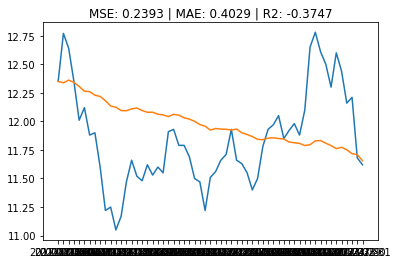

In [24]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_train['Close'])
plt.plot(predictions_ARIMA)
plt.title('MSE: %.4f | MAE: %.4f | R2: %.4f' % ( mean_squared_error(data_train['Close'], predictions_ARIMA), 
                                                 mean_absolute_error(data_train['Close'], predictions_ARIMA), 
                                                 r2_score(data_train['Close'], predictions_ARIMA)))

-0.46936244747724887


Text(0,0.5,'Concrete strength')

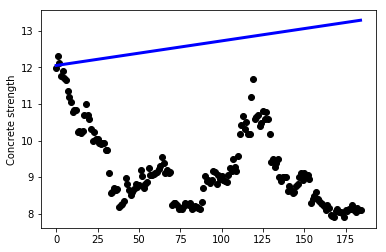

In [25]:
regr = LinearRegression()
x_train = [[x] for x in range(len(data_train))]
y_train = [[y] for y in list(data_train['Close'])]
x_test = [[z] for z in range(len(data_train), len(data_train)+len(data_test))]
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
print(explained_variance_score(data_test['Close'], y_pred))
plt.scatter(range(len(data_test)), data_test['Close'], color='black')
plt.plot(range(len(data_test)), y_pred, color='blue', linewidth=3)
plt.ylabel('Concrete strength')